# Parametric distribution on a manifold:

Knowing the expression of the geodesic distance on a manifold, we aim to look for the gradient flowing on the instance.

We will use a circle as a manifold for our two distributions and use the angle parametrization to compute the gradient flow.

In [ ]:
import pandas as pd
import numpy as np

nb_data = 50
np.random.seed(1)

x1 = pd.DataFrame(
    np.random.normal(
        loc=np.array([np.pi]), scale=np.array([np.pi / 8]), size=(nb_data, 1)
    )
) # angle distribution 1
x2 = pd.DataFrame(
    np.random.normal(loc=np.array([0]), scale=np.array([np.pi / 6]), size=(nb_data, 1))
) # angle distribution 2

In [ ]:
x1 = x1 % (2 * np.pi)
x2 = x2 % (2 * np.pi) 

In [ ]:
X1 = pd.concat([np.cos(x1[0]), np.sin(x1[0])], axis=1, keys=["x", "y"]) # convert to cartesian coordinates
X2 = pd.concat([np.cos(x2[0]), np.sin(x2[0])], axis=1, keys=["x", "y"])

In [ ]:
from random import choices
from imageio import imread
import torch

def load_image(fname):
    img = imread(fname, as_gray=True)  # Grayscale
    img = (img[::-1, :]) / 255.0
    return 1 - img


def draw_samples(fname, n, dtype=torch.FloatTensor):
    A = load_image(fname)
    xg, yg = np.meshgrid(
        np.linspace(0, 1, A.shape[0]),
        np.linspace(0, 1, A.shape[1]),
        indexing="xy",
    )

    grid = list(zip(xg.ravel(), yg.ravel()))
    dens = A.ravel() / A.sum()
    dots = np.array(choices(grid, dens, k=n))
    dots += (0.5 / A.shape[0]) * np.random.standard_normal(dots.shape)

    return torch.from_numpy(dots).type(dtype)


def display_samples(ax, x, color):
    x_ = x.detach().cpu().numpy()
    ax.scatter(x_[:, 0], x_[:, 1], 25 * 500 / len(x_), color, edgecolors="none")
    
def display_samples3D(ax, x, color):
    x_ = x.detach().cpu().numpy()
    ax.scatter(x_[:, 0], x_[:, 1], x_[:, 2], s=20, c=color, edgecolors="none")  # Set a fixed size


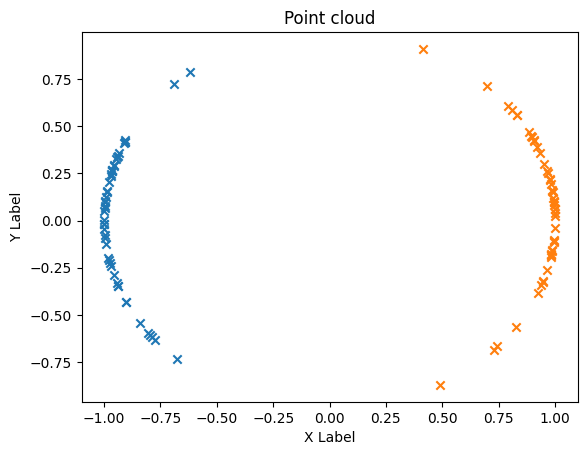

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Display the point cloud
ax.scatter(X1["x"], X1["y"], marker="x")
ax.scatter(X2["x"], X2["y"], marker="x")

ax.set_title("Point cloud")
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")

plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from geomloss import SamplesLoss

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [ ]:
X_i = torch.tensor(X1.values) # Convert to tensor
Y_j = torch.tensor(X2.values)

In [ ]:
def gradient_descent2D(loss, lr=1, verbose=False):
    """Flows along the gradient of the loss function.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = 1):
            Learning rate, i.e. time step.
    """
    if verbose:
        print("Launch Gradient Descent Algo on Sinkhorn")
    Nsteps = 20
    display_its = [0, 6, 12, 18]
    colors = (10 * X_i[:, 0]).cos() * (10 * X_i[:, 1]).cos()
    colors = colors.detach().cpu().numpy()

    x_i, y_j = X_i.clone(), Y_j.clone() # Clone the tensors to avoid modifying the original ones

    x_i.requires_grad = True

    t_0 = time.time()
    plt.figure(figsize=(12, 12))
    k = 1
    for i in range(Nsteps):

        if verbose:
            print(f"step {i}")
        L_ab = loss(x_i, y_j)
        [g] = torch.autograd.grad(L_ab, [x_i])

        if i in display_its: # Plot the positions of the samples at different iterations
            ax = plt.subplot(2, 2, k)
            k = k + 1
            plt.set_cmap("hsv")
            plt.scatter([10], [10])

            display_samples(ax, y_j, [(0.55, 0.55, 0.95)])
            display_samples(ax, x_i, colors)

            ax.set_title("it = {}".format(i))

            plt.axis([-1, 1, -1, 1])
            plt.gca().set_aspect("equal", adjustable="box")
            plt.xticks([], [])
            plt.yticks([], [])
            plt.tight_layout()

        x_i.data -= lr * len(x_i) * g
    plt.title(
        "it = {}, elapsed time: {:.2f}s/it".format(i, (time.time() - t_0) / Nsteps)
    )
    plt.savefig("./test.png")

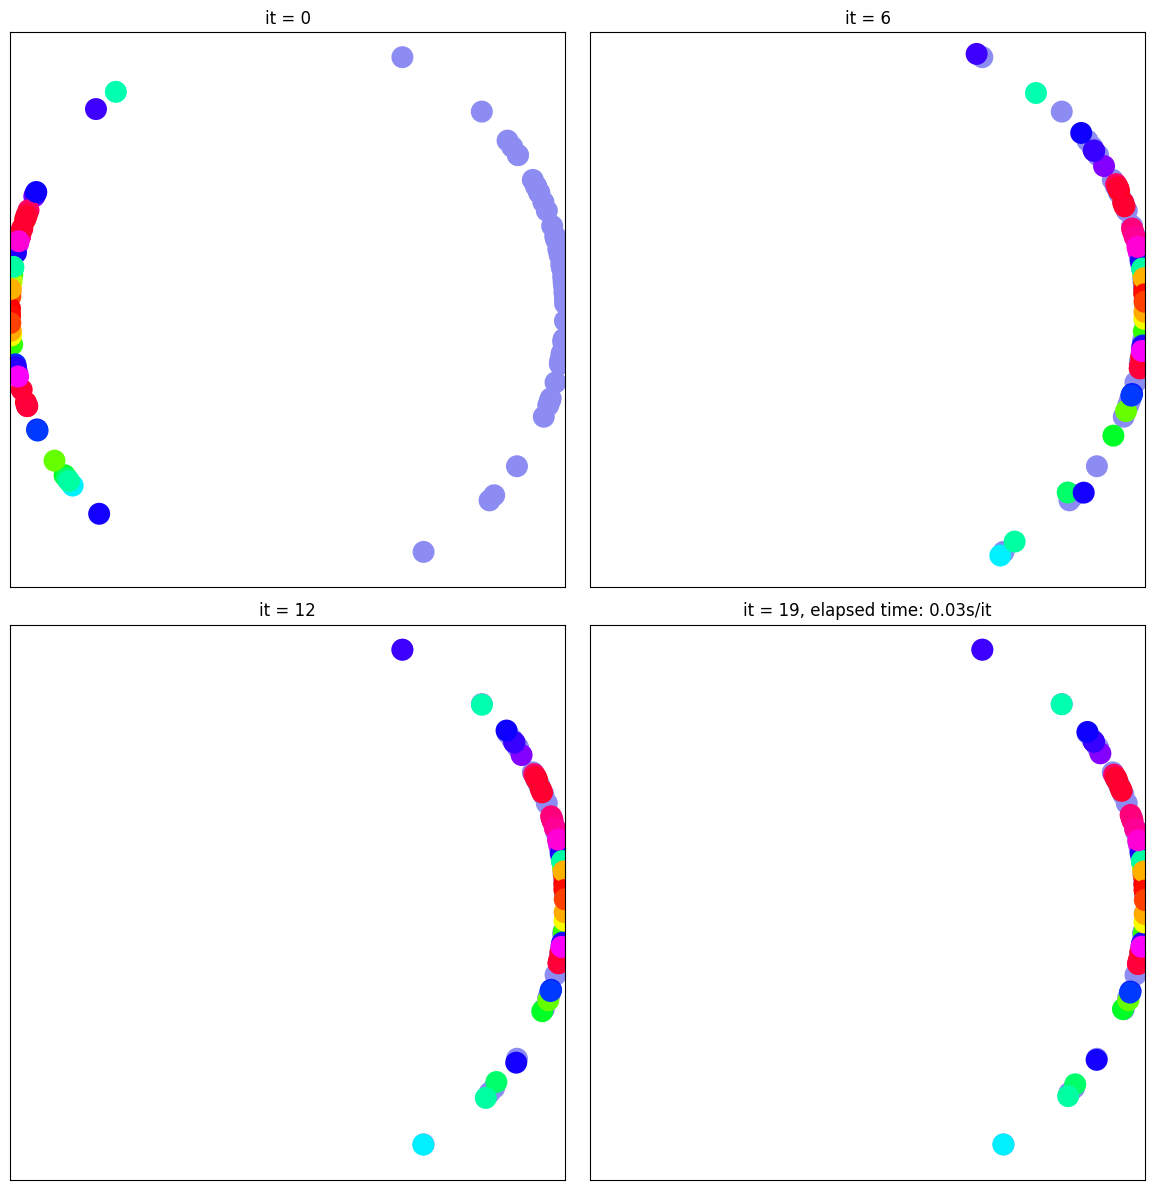

In [17]:
gradient_descent2D(SamplesLoss("sinkhorn", p=2, blur=0.1))

all tangent computed
Launch Gradient Descent Algo on Sinkhorn
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19


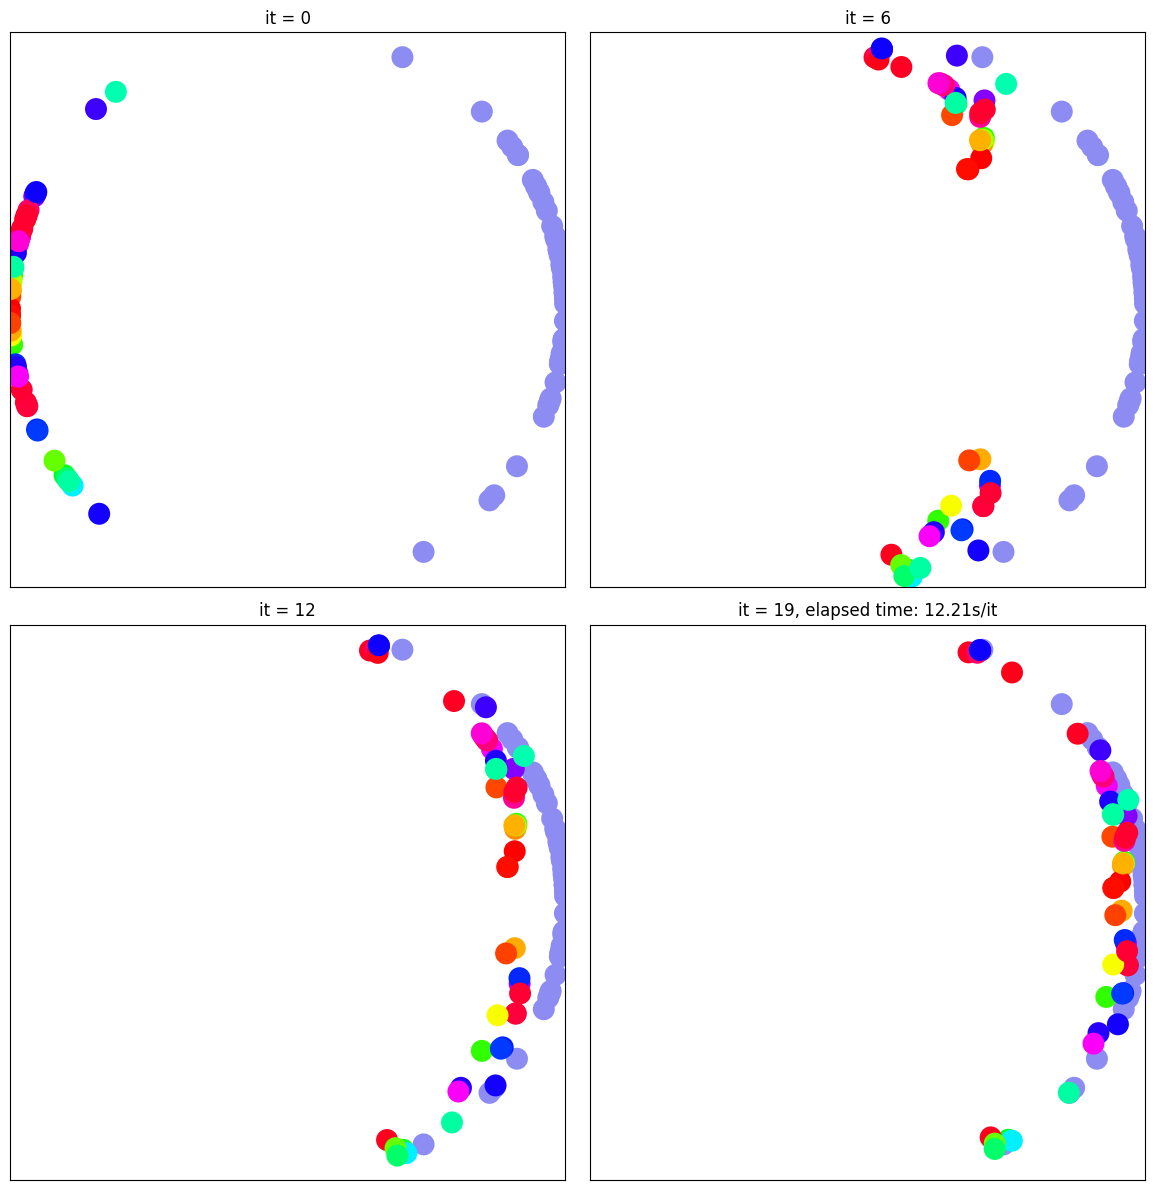

In [ ]:
from ManifoldProjectLoss import ManifoldProjection, BatchingCostModule
from gen_geometry import uniform_circ

data_circ = torch.tensor(uniform_circ(200))
cost = ManifoldProjection(
    data_circ, k_neighbor=5, closing_manifold_ratio=0.1, manifold_ratio=0.5
)
cost.precompute_all_cache()
print("all tangent computed")
cost_batched = BatchingCostModule(cost)
gradient_descent2D(
    SamplesLoss("sinkhorn", p=2, blur=0.1, cost=cost_batched), verbose=True, lr=0.1
) # Use the Wasserstein cost module